In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from numpy.core.numeric import _correlate_dispatcher
import pandas as pd
import scipy
from skmultilearn.model_selection import IterativeStratification
from utils.utils import makefolder_ifnotexists

class_names = ["MEL", "NV", "BKL"]  # remove the 9th "UNK" class
non_discriminative_feat_names = [
    "pigment_network", "globules", "negative_network", "streaks", "milia_like_cyst"]

discriminative_feat_names = [
    'pigmt_net_typical_includes_pseudonet',
    'dots_globs_reg',
    'negative_network',
    'strks_or_rad_strming',
    'MLCs_cloud',
    'granularity',
    'ker_plugs',
    'wobble',
    'scale',
    'blood',
    'atyp_net',
    'bld_vessels',
    'scarlike_regress',
    'ann_gran',
    'irreg_dots_globs',
    'blotch',
    'homog_tan_yellowish',
    'frambes_cerebriform_fernlike_pattern',
    'rough_covered_with_irreg_hyperkeratosis'
]




In [2]:
csv_dir = os.path.join('csv_files')
fold_save_dir = os.path.join('./data_folds/5foldTrainVal_featbalanced_no_lesion_id_leak')
makefolder_ifnotexists(fold_save_dir)

csv_file_my_train = os.path.join(csv_dir, 'Final_dataset_to_train.csv')

def add_dataset_class(source_df):
    source_df = source_df.replace({'dataset_class': r'.*?BCN.*\/?'}, {'dataset_class': 'BCN'}, regex=True)
    source_df = source_df.replace({'dataset_class': r'.*?HAM.*\/?'}, {'dataset_class': 'HAM'}, regex=True)
    source_df = source_df.replace({'dataset_class': r'.*?MSK.*\/?'}, {'dataset_class': 'MSK'}, regex=True)
    source_df = source_df.replace({'dataset_class':  r'.*?ISIC.*\/?'}, {'dataset_class': 'ISIC'}, regex=True)
    return source_df

In [3]:
isic_19_gt_meta_df = pd.read_csv('isic19_gt_meta.csv', skipinitialspace=True)
values = {'age_approx':0,	'anatom_site_general' : 'NA',	'lesion_id' : 'no_id',	'sex': 'unk'}
isic_19_gt_meta_df = isic_19_gt_meta_df.fillna(value=values)
isic_19_gt_meta_df.loc[(isic_19_gt_meta_df['lesion_id'] == 'no_id'), 'lesion_id'] = isic_19_gt_meta_df['image'][isic_19_gt_meta_df['lesion_id'] == 'no_id'] 
isic_19_gt_meta_df['dataset_class'] = isic_19_gt_meta_df['lesion_id']
unique_ids = isic_19_gt_meta_df.lesion_id.unique()

isic_19_gt_meta_df = add_dataset_class(isic_19_gt_meta_df)

In [4]:
isic_19_gt_meta_df_dset_percents = isic_19_gt_meta_df['dataset_class'].value_counts(normalize=True)


In [5]:
my_df = pd.read_csv(csv_file_my_train, skipinitialspace=True)
my_df = my_df.fillna(0)


In [6]:
my_df = my_df.merge(isic_19_gt_meta_df[['image', 'lesion_id']], how='inner', on='image')
my_df['dataset_class'] = my_df['lesion_id']

my_unique_ids = my_df.lesion_id.unique()

my_df = add_dataset_class(my_df)
my_df_dset_percents = my_df['dataset_class'].value_counts(normalize=True)

In [7]:
# my_df.to_csv('my_df_meta.csv')
def set_row_class(row):
    if row.MEL == 1:
        return 'MEL'
    if row.BKL == 1:
        return 'BKL'
    if row.NV == 1:
        return 'NV'

# create a column with class name
my_df['class'] = my_df.apply(lambda row: set_row_class(row), axis = 1)


In [8]:
# find rows with same lesion_id but different class names (i.e. diagnosis)
prob_df = my_df[my_df.groupby(['lesion_id'])['class'].transform('nunique') > 1]

# multiindexed df for extracting all rows with same lesion id
# e.g. heirarchical_df.xs(key="BCN_0001728", level="lesion_id")
heirarchical_df = my_df.set_index(["lesion_id", "image"])



In [9]:
data_df = my_df
class_dfs = {}
for class_ in class_names:
    class_dfs[class_] = data_df[data_df[class_] == 1]


In [10]:
n_splits = 5
order = 3
k_fold = IterativeStratification(n_splits=n_splits, order=order)

# classwise_fold = {}
train_final_folds = n_splits * [pd.DataFrame()]
val_final_folds = n_splits * [pd.DataFrame()]



In [11]:
for class_, class_df in class_dfs.items():
    stratification_on =  scipy.sparse.lil_matrix(class_df.loc[:,discriminative_feat_names].to_numpy())
    class_index_vals =  np.array(class_df.index.values.tolist()).transpose()
    fold_idx = 0
    for train_index, val_index in k_fold.split(class_df, stratification_on):

        train_diagfeat_discriminative_df  = class_df.iloc[train_index, :]
        val_diagfeat_discriminative_df = class_df.iloc[val_index, :]

        train_final_folds[fold_idx] = train_final_folds[fold_idx].append(train_diagfeat_discriminative_df)
        val_final_folds[fold_idx] =  val_final_folds[fold_idx].append(val_diagfeat_discriminative_df)
        fold_idx += 1


In [12]:
def get_value_counts(data_Series):
    value_list = list(data_Series.value_counts().values)
    if any(value_list):
        return value_list[0]
    else:
        return 0


In [13]:
# train and val sets for each fold. If a unique id is overrepresented in a set 
# then move all of that id to that set
my_df_lesion_id_cnts = my_df['lesion_id'].value_counts()
for fold_idx in range(n_splits):
    train_df = train_final_folds[fold_idx]
    val_df = val_final_folds[fold_idx]

    for lesion_id in list(my_df_lesion_id_cnts.keys()):
        train_lesion_id_df = train_df[train_df['lesion_id'] == lesion_id]
        train_lesion_id_cnts = get_value_counts(train_lesion_id_df['lesion_id'])
        
        val_lesion_id_df = val_df[val_df['lesion_id'] == lesion_id]
        val_lesion_id_cnts = get_value_counts(val_lesion_id_df['lesion_id'])
        if train_lesion_id_cnts <= val_lesion_id_cnts:
            # move rows to val dataset
            val_final_folds[fold_idx] = val_final_folds[fold_idx].append(train_lesion_id_df)
            train_final_folds[fold_idx] = train_final_folds[fold_idx].drop(train_lesion_id_df.index)

        else:
            # move rows to train dataset
            train_final_folds[fold_idx] = train_final_folds[fold_idx].append(val_lesion_id_df)
            val_final_folds[fold_idx] = val_final_folds[fold_idx].drop(val_lesion_id_df.index)



In [14]:
for idx in range(n_splits):
    train_fold_df = train_final_folds[idx]
    val_fold_df = val_final_folds[idx]

    bool_df = train_fold_df.isin({'lesion_id': list(val_fold_df['lesion_id'].unique()) })
    if bool_df['lesion_id'].sum() > 0:
        print('Data leak in fold {}'.format(idx))
    else:
        print('No data leak in {}'.format(idx))



No data leak in 0
No data leak in 1
No data leak in 2
No data leak in 3
No data leak in 4


In [15]:
for idx in range(n_splits):
    train_fold_df = train_final_folds[idx]
    val_fold_df = val_final_folds[idx]

    train_fold_df.to_csv(
        os.path.join(
            fold_save_dir,
            'train_featbalanced_{}fold{}.csv'.format(n_splits, idx)
        ),
        index=False, header=True
    )

    val_fold_df.to_csv(
        os.path.join(
            fold_save_dir,
            'val_featbalanced_{}fold{}.csv'.format(n_splits, idx)
        ),
        index=False, header=True
    )



In [17]:
sum_dict = {}

for idx in range(n_splits):
    train_fold_df = train_final_folds[idx]
    tr_s = train_fold_df.sum(numeric_only=True) 
    tr_s = tr_s[discriminative_feat_names] # / tr_s[discriminative_feat_names].sum()

    val_fold_df = val_final_folds[idx]
    vl_s = val_fold_df.sum(numeric_only=True)
    vl_s = vl_s[discriminative_feat_names] #/ vl_s[discriminative_feat_names].sum()

    sum_dict.update(
        {
            'tr_fld{}_feats'.format(idx): tr_s,
            'vl_fld{}_feats'.format(idx): vl_s,
        }
    )
    


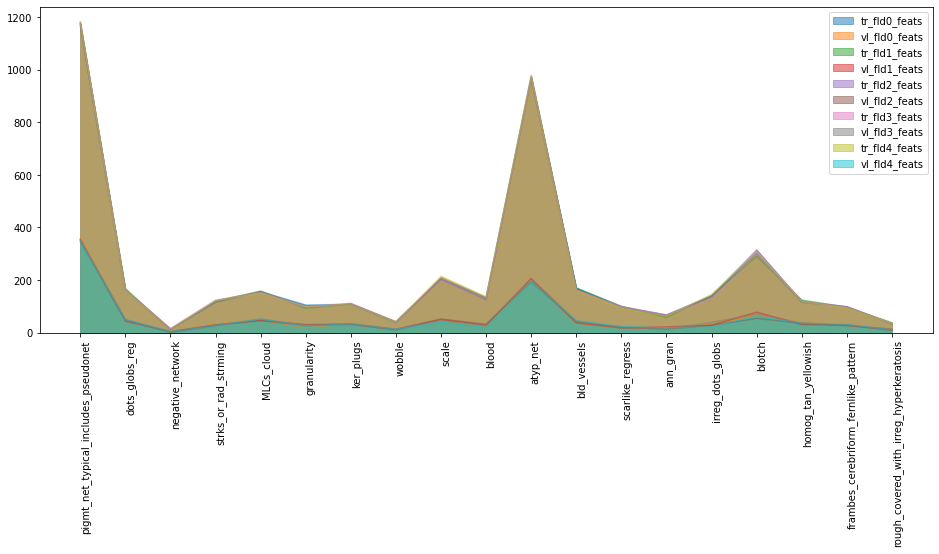

In [18]:
hist_df = pd.DataFrame(sum_dict).fillna(0.0)
ax = hist_df.plot.area(stacked=False, figsize=(16, 6));

# We want to show all ticks...
ax.set_xticks(np.arange(len(discriminative_feat_names)));
# ... and label them with the respective list entries
ax.set_xticklabels(discriminative_feat_names);

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor");


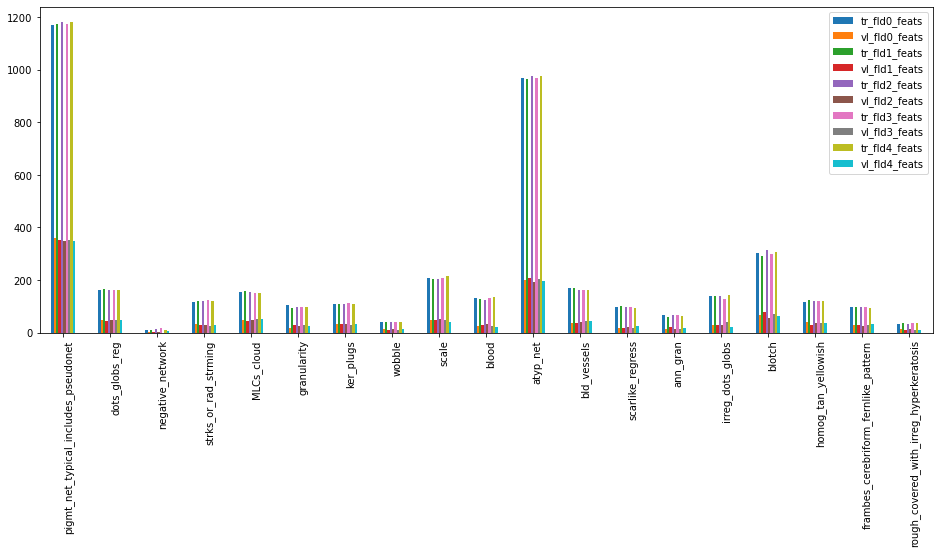

In [19]:
bar_df = pd.DataFrame(sum_dict).fillna(0.0)
ax = bar_df.plot.bar(figsize=(16, 6));

# We want to show all ticks...
ax.set_xticks(np.arange(len(discriminative_feat_names)));
# ... and label them with the respective list entries
ax.set_xticklabels(discriminative_feat_names);

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor");


In [23]:
from collections import Counter
from skmultilearn.model_selection.measures import \
    get_combination_wise_output_matrix

In [24]:
def get_orderwise_stats(stratification_on_arr, multilabel_names_list, order):
    cnt = Counter(combination for row in get_combination_wise_output_matrix(stratification_on_arr, order=order) for combination in row)
    # total_combo_cnt = 0
    combo_cnt_dict = {}
    for combo, count in cnt.items():
        combo = np.array(list(combo))
        # print(combo)
        check_key = np.sort(np.unique(combo)).tolist()
        check_key = tuple([multilabel_names_list[idx] for idx in check_key])
        if check_key not in combo_cnt_dict:
            combo_cnt_dict[check_key] = count
            # total_combo_cnt += count
    return combo_cnt_dict





In [25]:
def get_orderwise_count_dict(set_df, set_name, multilabel_names_list, order):
    stratification_on_full_set = set_df.loc[:, discriminative_feat_names].to_numpy()
    stratification_on_for_mel = set_df[set_df['MEL'] == 1].loc[:, discriminative_feat_names].to_numpy()
    stratification_on_for_bkl = set_df[set_df['BKL'] == 1].loc[:, discriminative_feat_names].to_numpy()
    stratification_on_for_nv = set_df[set_df['NV'] == 1].loc[:, discriminative_feat_names].to_numpy()
    return {
        '{}_set'.format(set_name): get_orderwise_stats(stratification_on_full_set, multilabel_names_list, order),
        '{}_MEL'.format(set_name): get_orderwise_stats(stratification_on_for_mel, multilabel_names_list, order),
        '{}_BKL'.format(set_name): get_orderwise_stats(stratification_on_for_bkl, multilabel_names_list, order),
        '{}_NV'.format(set_name): get_orderwise_stats(stratification_on_for_nv, multilabel_names_list, order),
    }

In [26]:
combined_set_dict = {}

combined_set_dict.update(
    get_orderwise_count_dict(
        class_df, 'full', discriminative_feat_names, order=order
    )
)

for idx in range(n_splits):
    train_fold_df = train_final_folds[idx]
    val_fold_df = val_final_folds[idx]

    combined_set_dict.update(
        get_orderwise_count_dict(
            train_fold_df, 'train_Fold{}'.format(idx),
            discriminative_feat_names, order=order
        )
    )
    combined_set_dict.update(
        get_orderwise_count_dict(
            val_fold_df, 'val_Fold{}'.format(idx),
            discriminative_feat_names, order=order
        )
    )

In [27]:
combined_set_dict

{'full_set': {('MLCs_cloud', 'ker_plugs'): 67,
  ('MLCs_cloud', 'irreg_dots_globs'): 8,
  ('bld_vessels', 'irreg_dots_globs'): 2,
  ('bld_vessels', 'irreg_dots_globs', 'blotch'): 1,
  ('ker_plugs', 'bld_vessels'): 12,
  ('ker_plugs', 'bld_vessels', 'irreg_dots_globs'): 1,
  ('MLCs_cloud', 'bld_vessels'): 13,
  ('MLCs_cloud', 'blotch'): 6,
  ('bld_vessels', 'blotch'): 4,
  ('MLCs_cloud', 'ker_plugs', 'bld_vessels'): 6,
  ('ker_plugs', 'bld_vessels', 'blotch'): 1,
  ('ker_plugs', 'blotch'): 5,
  ('MLCs_cloud', 'ker_plugs', 'blotch'): 2,
  ('ker_plugs', 'irreg_dots_globs'): 4,
  ('MLCs_cloud', 'ker_plugs', 'irreg_dots_globs'): 2,
  ('irreg_dots_globs', 'blotch'): 6,
  ('irreg_dots_globs',): 47,
  ('blotch',): 41,
  ('ker_plugs', 'irreg_dots_globs', 'blotch'): 1,
  ('ker_plugs',): 136,
  ('MLCs_cloud',): 195,
  ('MLCs_cloud', 'bld_vessels', 'irreg_dots_globs'): 1,
  ('bld_vessels',): 86,
  ('MLCs_cloud', 'bld_vessels', 'blotch'): 3,
  ('MLCs_cloud', 'irreg_dots_globs', 'blotch'): 2,
  ('wo

In [28]:
combined_stats_df = pd.DataFrame(combined_set_dict).fillna(0.0)


In [29]:
combined_stats_df

full_set  \
MLCs_cloud                           ker_plugs        NaN                       0.0   
                                     irreg_dots_globs NaN                       0.0   
bld_vessels                          irreg_dots_globs NaN                       0.0   
                                                      blotch                    1.0   
ker_plugs                            bld_vessels      NaN                       0.0   
...                                                                             ...   
negative_network                     atyp_net         irreg_dots_globs          0.0   
                                                      ann_gran                  0.0   
                                     ann_gran         NaN                       0.0   
pigmt_net_typical_includes_pseudonet bld_vessels      homog_tan_yellowish       0.0   
strks_or_rad_strming                 MLCs_cloud       atyp_net                  0.0   

                                                                           full_MEL  \
MLCs_cloud                           ker_plugs        NaN                       0.0   
                                     irreg_dots_globs NaN                       0.0   
bld_vessels                          irreg_dots_globs NaN                       0.0   
                                                      blotch                    0.0   
ker_plugs                            bld_vessels      NaN                       0.0   
...                                                                             ...   
negative_network                     atyp_net         irreg_dots_globs          0.0   
                                                      ann_gran                  0.0   
                                     ann_gran         NaN                       0.0   
pigmt_net_typical_includes_pseudonet bld_vessels      homog_tan_yellowish       0.0   
strks_or_rad_strming                 MLCs_cloud       atyp_net                  0.0   

                                                                           full_BKL  \
MLCs_cloud                           ker_plugs        NaN                       0.0   
                                     irreg_dots_globs NaN                       0.0   
bld_vessels                          irreg_dots_globs NaN                       0.0   
                                                      blotch                    1.0   
ker_plugs                            bld_vessels      NaN                       0.0   
...                                                                             ...   
negative_network                     atyp_net         irreg_dots_globs          0.0   
                                                      ann_gran                  0.0   
                                     ann_gran         NaN                       0.0   
pigmt_net_typical_includes_pseudonet bld_vessels      homog_tan_yellowish       0.0   
strks_or_rad_strming                 MLCs_cloud       atyp_net                  0.0   

                                                                           full_NV  \
MLCs_cloud                           ker_plugs        NaN                      0.0   
                                     irreg_dots_globs NaN                      0.0   
bld_vessels                          irreg_dots_globs NaN                      0.0   
                                                      blotch                   0.0   
ker_plugs                            bld_vessels      NaN                      0.0   
...                                                                            ...   
negative_network                     atyp_net         irreg_dots_globs         0.0   
                                                      ann_gran                 0.0   
                                     ann_gran         NaN                      0.0   
pigmt_net_typical_includes_pseudonet bld_vessels      homog_tan_yellowish      0

In [30]:
combined_stats_df.to_csv('order3_new.csv')

In [31]:
combined_stats_df.unstack(level=0)

full_set           \
                                                   MLCs_cloud ann_gran   
NaN        NaN                                            0.0      0.0   
MLCs_cloud NaN                                            NaN      NaN   
           ann_gran                                       NaN      NaN   
           atyp_net                                       NaN      NaN   
           bld_vessels                                    NaN      NaN   
...                                                       ...      ...   
wobble     blood                                          2.0      NaN   
           frambes_cerebriform_fernlike_pattern           0.0      NaN   
           homog_tan_yellowish                            NaN      NaN   
           rough_covered_with_irreg_hyperkeratosis        NaN      NaN   
           scale                                          3.0      NaN   

                                                                               \
                                                   atyp_net bld_vessels blood   
NaN        NaN                                          0.0         0.0   0.0   
MLCs_cloud NaN                                          NaN         NaN   NaN   
           ann_gran                                     NaN         NaN   NaN   
           atyp_net                                     NaN         NaN   NaN   
           bld_vessels                                  NaN         NaN   NaN   
...                                                     ...         ...   ...   
wobble     blood                                        NaN         NaN   NaN   
           frambes_cerebriform_fernlike_pattern         NaN         NaN   NaN   
           homog_tan_yellowish                          NaN         NaN   NaN   
           rough_covered_with_irreg_hyperkeratosis      NaN         NaN   NaN   
           scale                                        NaN         NaN   NaN   

                                                                          \
                                                   blotch dots_globs_reg   
NaN        NaN                                        0.0            0.0   
MLCs_cloud NaN                                        NaN            0.0   
           ann_gran                                   NaN            NaN   
           atyp_net                                   NaN            NaN   
           bld_vessels                                NaN            NaN   
...                                                   ...            ...   
wobble     blood                                      NaN            NaN   
           frambes_cerebriform_fernlike_pattern       NaN            NaN   
           homog_tan_yellowish                        NaN            NaN   
           rough_covered_with_irreg_hyperkeratosis    NaN            NaN   
           scale                                      NaN            NaN   

                                                                                         \
                                                   frambes_cerebriform_fernlike_pattern   
NaN        NaN                                                                      0.0   
MLCs_cloud NaN                                                                      NaN   
           ann_gran                                                                 NaN   
           atyp_net                                                                 NaN   
           bld_vessels                                                              NaN   
...                                                                                 ...   
wobble     blood                                                                    NaN   
           frambes_cerebriform_fernlike_pattern                                     NaN   
           homog_tan_yellowish                                                      NaN   
           rough_covered_with_irreg_hyperkerat

In [32]:
combined_stats_df.unstack(level=-1)

full_set             \
                                                        NaN MLCs_cloud   
MLCs_cloud NaN                                          0.0        NaN   
           ann_gran                                     0.0        NaN   
           atyp_net                                     0.0        NaN   
           bld_vessels                                  0.0        NaN   
           blood                                        0.0        NaN   
...                                                     ...        ...   
wobble     blood                                        0.0        NaN   
           frambes_cerebriform_fernlike_pattern         0.0        NaN   
           homog_tan_yellowish                          0.0        NaN   
           rough_covered_with_irreg_hyperkeratosis      0.0        NaN   
           scale                                        0.0        NaN   

                                                                      \
                                                   ann_gran atyp_net   
MLCs_cloud NaN                                          NaN      NaN   
           ann_gran                                     NaN      NaN   
           atyp_net                                     0.0      NaN   
           bld_vessels                                  NaN      NaN   
           blood                                        NaN      NaN   
...                                                     ...      ...   
wobble     blood                                        NaN      NaN   
           frambes_cerebriform_fernlike_pattern         NaN      NaN   
           homog_tan_yellowish                          NaN      NaN   
           rough_covered_with_irreg_hyperkeratosis      NaN      NaN   
           scale                                        NaN      NaN   

                                                                             \
                                                   bld_vessels blood blotch   
MLCs_cloud NaN                                             NaN   NaN    NaN   
           ann_gran                                        NaN   NaN    0.0   
           atyp_net                                        1.0   NaN    0.0   
           bld_vessels                                     NaN   NaN    3.0   
           blood                                           3.0   NaN    NaN   
...                                                        ...   ...    ...   
wobble     blood                                           2.0   NaN    NaN   
           frambes_cerebriform_fernlike_pattern            NaN   NaN    NaN   
           homog_tan_yellowish                             NaN   NaN    NaN   
           rough_covered_with_irreg_hyperkeratosis         NaN   NaN    NaN   
           scale                                           NaN   2.0    NaN   

                                                                                         \
                                                   frambes_cerebriform_fernlike_pattern   
MLCs_cloud NaN                                                                      NaN   
           ann_gran                                                                 NaN   
           atyp_net                                                                 NaN   
           bld_vessels                                                              1.0   
           blood                                                                    NaN   
...                                                                                 ...   
wobble     blood                                                                    1.0   
           frambes_cerebriform_fernlike_pattern                                     NaN   
           homog_tan_yellowish                                                      NaN   
           rough_covered_with_irreg_hyperkeratosis                                  NaN   
           scale               

In [33]:
combined_stats_df.unstack(level=1)

full_set             \
                                                        NaN MLCs_cloud   
MLCs_cloud NaN                                          0.0        NaN   
           ann_gran                                     NaN        NaN   
           atyp_net                                     NaN        NaN   
           bld_vessels                                  NaN        NaN   
           blood                                        NaN        NaN   
...                                                     ...        ...   
wobble     bld_vessels                                  NaN        NaN   
           blood                                        NaN        NaN   
           frambes_cerebriform_fernlike_pattern         NaN        NaN   
           homog_tan_yellowish                          NaN        NaN   
           rough_covered_with_irreg_hyperkeratosis      NaN        NaN   

                                                                      \
                                                   ann_gran atyp_net   
MLCs_cloud NaN                                          0.0      0.0   
           ann_gran                                     NaN      0.0   
           atyp_net                                     NaN      NaN   
           bld_vessels                                  NaN      1.0   
           blood                                        NaN      NaN   
...                                                     ...      ...   
wobble     bld_vessels                                  NaN      NaN   
           blood                                        NaN      NaN   
           frambes_cerebriform_fernlike_pattern         NaN      NaN   
           homog_tan_yellowish                          NaN      NaN   
           rough_covered_with_irreg_hyperkeratosis      NaN      NaN   

                                                                             \
                                                   bld_vessels blood blotch   
MLCs_cloud NaN                                             0.0   0.0    0.0   
           ann_gran                                        NaN   NaN    NaN   
           atyp_net                                        NaN   NaN    NaN   
           bld_vessels                                     NaN   3.0    NaN   
           blood                                           NaN   NaN    NaN   
...                                                        ...   ...    ...   
wobble     bld_vessels                                     NaN   2.0    NaN   
           blood                                           NaN   NaN    NaN   
           frambes_cerebriform_fernlike_pattern            2.0   1.0    NaN   
           homog_tan_yellowish                             NaN   NaN    NaN   
           rough_covered_with_irreg_hyperkeratosis         1.0   1.0    NaN   

                                                                   \
                                                   dots_globs_reg   
MLCs_cloud NaN                                                NaN   
           ann_gran                                           NaN   
           atyp_net                                           NaN   
           bld_vessels                                        NaN   
           blood                                              NaN   
...                                                           ...   
wobble     bld_vessels                                        NaN   
           blood                                              NaN   
           frambes_cerebriform_fernlike_pattern               NaN   
           homog_tan_yellowish                                NaN   
           rough_covered_with_irreg_hyperkeratosis            NaN   

                                                                                         \
                                                   frambes_cerebriform_fernlike_pattern   
MLCs_cloud NaN                             

In [34]:
combined_stats_df.unstack(level=2)

full_set             \
                                                        NaN MLCs_cloud   
MLCs_cloud NaN                                          0.0        NaN   
           ann_gran                                     0.0        NaN   
           atyp_net                                     0.0        NaN   
           bld_vessels                                  0.0        NaN   
           blood                                        0.0        NaN   
...                                                     ...        ...   
wobble     blood                                        0.0        NaN   
           frambes_cerebriform_fernlike_pattern         0.0        NaN   
           homog_tan_yellowish                          0.0        NaN   
           rough_covered_with_irreg_hyperkeratosis      0.0        NaN   
           scale                                        0.0        NaN   

                                                                      \
                                                   ann_gran atyp_net   
MLCs_cloud NaN                                          NaN      NaN   
           ann_gran                                     NaN      NaN   
           atyp_net                                     0.0      NaN   
           bld_vessels                                  NaN      NaN   
           blood                                        NaN      NaN   
...                                                     ...      ...   
wobble     blood                                        NaN      NaN   
           frambes_cerebriform_fernlike_pattern         NaN      NaN   
           homog_tan_yellowish                          NaN      NaN   
           rough_covered_with_irreg_hyperkeratosis      NaN      NaN   
           scale                                        NaN      NaN   

                                                                             \
                                                   bld_vessels blood blotch   
MLCs_cloud NaN                                             NaN   NaN    NaN   
           ann_gran                                        NaN   NaN    0.0   
           atyp_net                                        1.0   NaN    0.0   
           bld_vessels                                     NaN   NaN    3.0   
           blood                                           3.0   NaN    NaN   
...                                                        ...   ...    ...   
wobble     blood                                           2.0   NaN    NaN   
           frambes_cerebriform_fernlike_pattern            NaN   NaN    NaN   
           homog_tan_yellowish                             NaN   NaN    NaN   
           rough_covered_with_irreg_hyperkeratosis         NaN   NaN    NaN   
           scale                                           NaN   2.0    NaN   

                                                                                         \
                                                   frambes_cerebriform_fernlike_pattern   
MLCs_cloud NaN                                                                      NaN   
           ann_gran                                                                 NaN   
           atyp_net                                                                 NaN   
           bld_vessels                                                              1.0   
           blood                                                                    NaN   
...                                                                                 ...   
wobble     blood                                                                    1.0   
           frambes_cerebriform_fernlike_pattern                                     NaN   
           homog_tan_yellowish                                                      NaN   
           rough_covered_with_irreg_hyperkeratosis                                  NaN   
           scale               

In [36]:
combined_stats_df.unstack(level=2)

full_set             \
                                                        NaN MLCs_cloud   
MLCs_cloud NaN                                          0.0        NaN   
           ann_gran                                     0.0        NaN   
           atyp_net                                     0.0        NaN   
           bld_vessels                                  0.0        NaN   
           blood                                        0.0        NaN   
...                                                     ...        ...   
wobble     blood                                        0.0        NaN   
           frambes_cerebriform_fernlike_pattern         0.0        NaN   
           homog_tan_yellowish                          0.0        NaN   
           rough_covered_with_irreg_hyperkeratosis      0.0        NaN   
           scale                                        0.0        NaN   

                                                                      \
                                                   ann_gran atyp_net   
MLCs_cloud NaN                                          NaN      NaN   
           ann_gran                                     NaN      NaN   
           atyp_net                                     0.0      NaN   
           bld_vessels                                  NaN      NaN   
           blood                                        NaN      NaN   
...                                                     ...      ...   
wobble     blood                                        NaN      NaN   
           frambes_cerebriform_fernlike_pattern         NaN      NaN   
           homog_tan_yellowish                          NaN      NaN   
           rough_covered_with_irreg_hyperkeratosis      NaN      NaN   
           scale                                        NaN      NaN   

                                                                             \
                                                   bld_vessels blood blotch   
MLCs_cloud NaN                                             NaN   NaN    NaN   
           ann_gran                                        NaN   NaN    0.0   
           atyp_net                                        1.0   NaN    0.0   
           bld_vessels                                     NaN   NaN    3.0   
           blood                                           3.0   NaN    NaN   
...                                                        ...   ...    ...   
wobble     blood                                           2.0   NaN    NaN   
           frambes_cerebriform_fernlike_pattern            NaN   NaN    NaN   
           homog_tan_yellowish                             NaN   NaN    NaN   
           rough_covered_with_irreg_hyperkeratosis         NaN   NaN    NaN   
           scale                                           NaN   2.0    NaN   

                                                                                         \
                                                   frambes_cerebriform_fernlike_pattern   
MLCs_cloud NaN                                                                      NaN   
           ann_gran                                                                 NaN   
           atyp_net                                                                 NaN   
           bld_vessels                                                              1.0   
           blood                                                                    NaN   
...                                                                                 ...   
wobble     blood                                                                    1.0   
           frambes_cerebriform_fernlike_pattern                                     NaN   
           homog_tan_yellowish                                                      NaN   
           rough_covered_with_irreg_hyperkeratosis                                  NaN   
           scale               

In [37]:
list(set([ (2,2),(2,3),(1,4),(4,1),(2,2) ]))

[(4, 1), (2, 3), (1, 4), (2, 2)]

In [38]:
combined_stats_df.index.to_flat_index()

Index([                                              ('MLCs_cloud', 'ker_plugs', nan),
                                              ('MLCs_cloud', 'irreg_dots_globs', nan),
                                             ('bld_vessels', 'irreg_dots_globs', nan),
                                        ('bld_vessels', 'irreg_dots_globs', 'blotch'),
                                                    ('ker_plugs', 'bld_vessels', nan),
                                     ('ker_plugs', 'bld_vessels', 'irreg_dots_globs'),
                                                   ('MLCs_cloud', 'bld_vessels', nan),
                                                        ('MLCs_cloud', 'blotch', nan),
                                                       ('bld_vessels', 'blotch', nan),
                                           ('MLCs_cloud', 'ker_plugs', 'bld_vessels'),
       ...
                                            ('scale', 'atyp_net', 'scarlike_regress'),
                                

In [39]:
combined_stats_df.index.to_flat_index().values

array([('MLCs_cloud', 'ker_plugs', nan),
       ('MLCs_cloud', 'irreg_dots_globs', nan),
       ('bld_vessels', 'irreg_dots_globs', nan),
       ('bld_vessels', 'irreg_dots_globs', 'blotch'),
       ('ker_plugs', 'bld_vessels', nan),
       ('ker_plugs', 'bld_vessels', 'irreg_dots_globs'),
       ('MLCs_cloud', 'bld_vessels', nan), ('MLCs_cloud', 'blotch', nan),
       ('bld_vessels', 'blotch', nan),
       ('MLCs_cloud', 'ker_plugs', 'bld_vessels'),
       ('ker_plugs', 'bld_vessels', 'blotch'),
       ('ker_plugs', 'blotch', nan),
       ('MLCs_cloud', 'ker_plugs', 'blotch'),
       ('ker_plugs', 'irreg_dots_globs', nan),
       ('MLCs_cloud', 'ker_plugs', 'irreg_dots_globs'),
       ('irreg_dots_globs', 'blotch', nan),
       ('irreg_dots_globs', nan, nan), ('blotch', nan, nan),
       ('ker_plugs', 'irreg_dots_globs', 'blotch'),
       ('ker_plugs', nan, nan), ('MLCs_cloud', nan, nan),
       ('MLCs_cloud', 'bld_vessels', 'irreg_dots_globs'),
       ('bld_vessels', nan, nan), ('MLC

In [52]:
my_df_lesion_id_cnts_list = list(my_df_lesion_id_cnts.keys())
cleaned_isic19_df = isic_19_gt_meta_df[isic_19_gt_meta_df['lesion_id'].isin(my_df_lesion_id_cnts_list)]


In [53]:
cleaned_isic19_df

image  MEL  NV  BCC  AK  BKL  DF  VASC  SCC  UNK  \
2                  ISIC_0000002    1   0    0   0    0   0     0    0    0   
21     ISIC_0000022_downsampled    1   0    0   0    0   0     0    0    0   
25     ISIC_0000026_downsampled    1   0    0   0    0   0     0    0    0   
29     ISIC_0000030_downsampled    1   0    0   0    0   0     0    0    0   
34     ISIC_0000036_downsampled    1   0    0   0    0   0     0    0    0   
...                         ...  ...  ..  ...  ..  ...  ..   ...  ...  ...   
25316              ISIC_0073231    1   0    0   0    0   0     0    0    0   
25319              ISIC_0073237    1   0    0   0    0   0     0    0    0   
25320              ISIC_0073238    1   0    0   0    0   0     0    0    0   
25322              ISIC_0073241    1   0    0   0    0   0     0    0    0   
25328              ISIC_0073249    1   0    0   0    0   0     0    0    0   

       age_approx anatom_site_general                 lesion_id     sex  \
2            60.0     upper extremity              ISIC_0000002  female   
21           55.0     lower extremity  ISIC_0000022_downsampled  female   
25           30.0     lower extremity  ISIC_0000026_downsampled  female   
29           55.0     lower extremity  ISIC_0000030_downsampled  female   
34           70.0     upper extremity  ISIC_0000036_downsampled    male   
...           ...                 ...                       ...     ...   
25316        55.0      anterior torso               BCN_0005418  female   
25319        45.0     lower extremity               BCN_0001536  female   
25320        45.0     upper extremity               BCN_0005240  female   
25322        60.0         palms/soles               BCN_0004405    male   
25328        70.0     lower extremity               BCN_0001085    male   

      dataset_class  
2              ISIC  
21             ISIC  
25             ISIC  
29             ISIC  
34             ISIC  
...             ...  
25316           BCN  
25319           BCN  
25320           BCN  
25322           BCN  
25328           BCN  

[6919 rows x 15 columns]

In [58]:
my_df[my_df['MEL'] == 1]['dataset_class'].value_counts()

BCN     1201
HAM       18
ISIC      12
Name: dataset_class, dtype: int64

In [59]:
my_df[my_df['BKL'] == 1]['dataset_class'].value_counts()

HAM     996
ISIC     90
MSK      76
Name: dataset_class, dtype: int64

In [60]:
my_df[my_df['NV'] == 1]['dataset_class'].value_counts()

BCN    755
HAM    447
Name: dataset_class, dtype: int64

In [62]:
cleaned_isic19_df[cleaned_isic19_df['MEL'] == 1]['dataset_class'].value_counts()

HAM     1081
ISIC     325
BCN      219
MSK      215
Name: dataset_class, dtype: int64

In [63]:
cleaned_isic19_df[cleaned_isic19_df['BKL'] == 1]['dataset_class'].value_counts()

BCN     1138
MSK      113
ISIC     108
HAM       41
Name: dataset_class, dtype: int64

In [64]:
cleaned_isic19_df[cleaned_isic19_df['NV'] == 1]['dataset_class'].value_counts()

HAM     5947
BCN     1951
ISIC    1549
MSK      415
Name: dataset_class, dtype: int64

In [96]:
test_df['dataset_class'].value_counts()

BCN     300
MSK     300
ISIC    300
HAM     241
Name: dataset_class, dtype: int64

In [97]:
test_df['MEL'].value_counts()

0    741
1    400
Name: MEL, dtype: int64

In [98]:
test_df['BKL'].value_counts()

0    800
1    341
Name: BKL, dtype: int64

In [99]:
test_df['NV'].value_counts()

0    741
1    400
Name: NV, dtype: int64